In [1]:
!pip install -qU torch_snippets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
from torch_snippets import *
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import pandas as pd
import glob
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMG_ROOT = '/kaggle/input/car-object-detection/data/training_images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
df =pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df = df.rename(columns={'image' : 'ImageID'})
df

ImageID        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

In [4]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

(501, 58)

In [5]:
label2target = {'background': 0 , 'car' : 1  }
target2label = { t: l for l,t in  label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [6]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [7]:
class OpenDataset(Dataset):
    def __init__(self, df, image_dir):
        self.w, self.h = 224, 224
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df.copy()
        self.image_infos = df.ImageID.unique()
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        data = self.df[self.df['ImageID'] == image_id]
        H, W , _ = np.array(img).shape
        data.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] /= [W, H, W, H]
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        labels = ['car'] * len(data)
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() 
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [8]:
train_ds = OpenDataset(trn_df, IMG_ROOT)
test_ds = OpenDataset(val_df , IMG_ROOT)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [9]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features # number of input channels
                                                    , num_classes)
    return model

In [10]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [11]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 10
log = Report(n_epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:09<00:00, 17.5MB/s] 


In [12]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)
     

EPOCH: 2.000  trn_rpn_box_reg_loss: 0.002  val_objectness_loss: 0.001  val_rpn_box_reg_loss: 0.003  trn_loc_loss: 0.037  trn_loss: 0.154  val_loss: 0.163  val_regr_loss: 0.116  trn_objectness_loss: 0.001  trn_regr_loss: 0.114  val_loc_loss: 0.044  (76.47s - 305.86s remaining)
EPOCH: 4.000  trn_rpn_box_reg_loss: 0.001  val_objectness_loss: 0.001  val_rpn_box_reg_loss: 0.003  trn_loc_loss: 0.028  trn_loss: 0.107  val_loss: 0.149  val_regr_loss: 0.105  trn_objectness_loss: 0.000  trn_regr_loss: 0.077  val_loc_loss: 0.041  (149.67s - 224.50s remaining)
EPOCH: 6.000  trn_rpn_box_reg_loss: 0.001  val_objectness_loss: 0.001  val_rpn_box_reg_loss: 0.003  trn_loc_loss: 0.024  trn_loss: 0.093  val_loss: 0.167  val_regr_loss: 0.115  trn_objectness_loss: 0.000  trn_regr_loss: 0.068  val_loc_loss: 0.048  (223.06s - 148.71s remaining)
EPOCH: 8.000  trn_rpn_box_reg_loss: 0.001  val_objectness_loss: 0.001  val_rpn_box_reg_loss: 0.003  trn_loc_loss: 0.025  trn_loss: 0.111  val_loss: 0.174  val_regr_los

In [13]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

4

torch.Size([3, 224, 224])

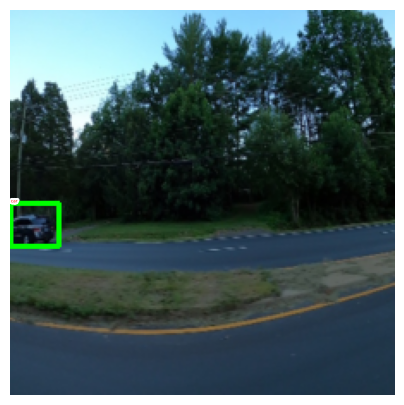

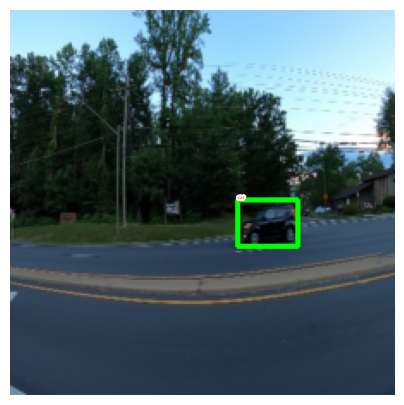

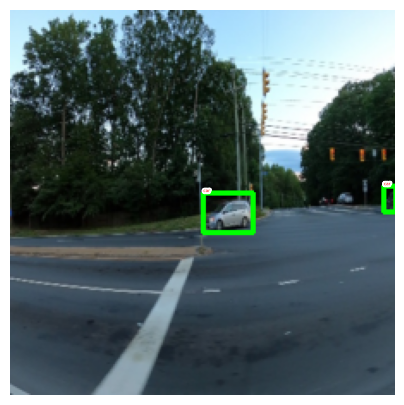

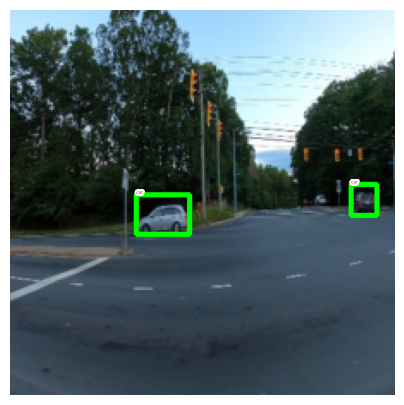

4

torch.Size([3, 224, 224])

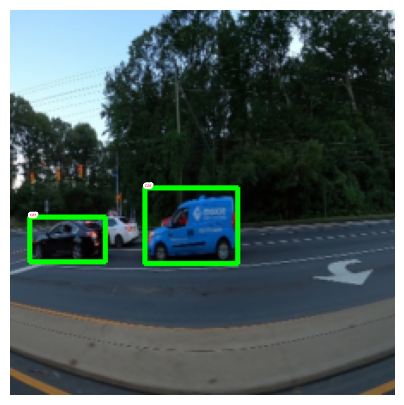

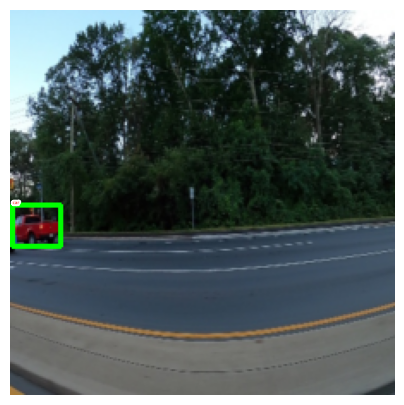

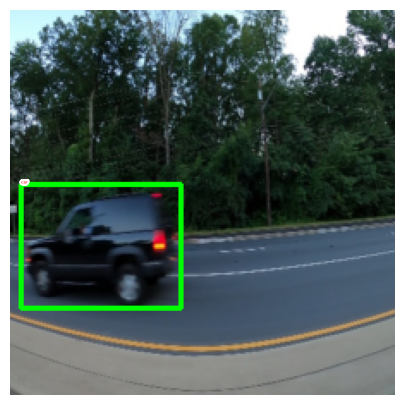

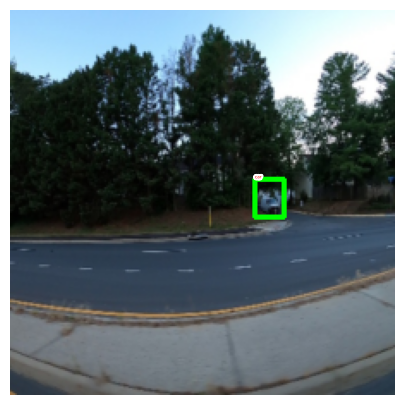

4

torch.Size([3, 224, 224])

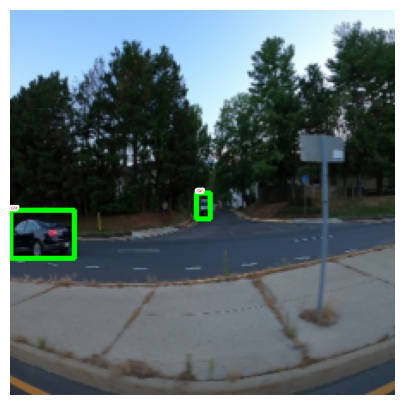

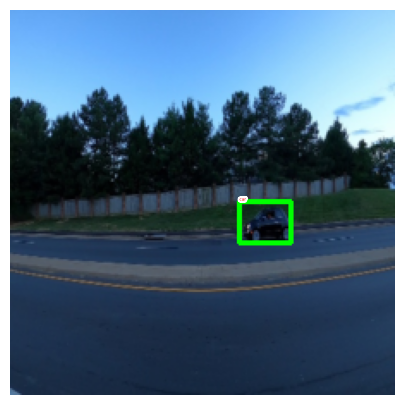

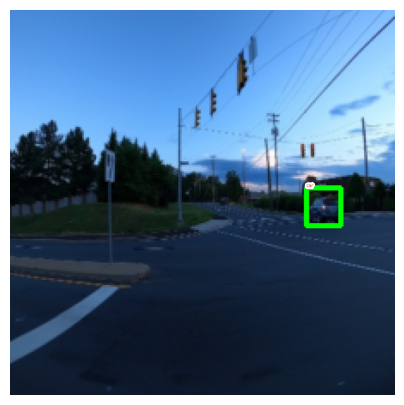

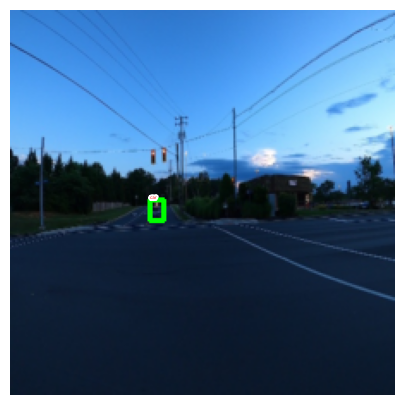

4

In [28]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    print(len(images))
    if ix==3: break
    images = [im for im in images]
    print(images[0].size())
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

tensor([[[0.6784, 0.6784, 0.6784,  ..., 0.6235, 0.6275, 0.6275],
         [0.6784, 0.6824, 0.6863,  ..., 0.6314, 0.6314, 0.6314],
         [0.6824, 0.6824, 0.6824,  ..., 0.6353, 0.6314, 0.6353],
         ...,
         [0.1529, 0.1451, 0.1490,  ..., 0.1294, 0.1294, 0.1216],
         [0.1490, 0.1451, 0.1490,  ..., 0.1255, 0.1255, 0.1176],
         [0.1412, 0.1412, 0.1451,  ..., 0.1294, 0.1294, 0.1176]],

        [[0.9176, 0.9176, 0.9176,  ..., 0.8627, 0.8667, 0.8667],
         [0.9176, 0.9216, 0.9255,  ..., 0.8706, 0.8706, 0.8706],
         [0.9216, 0.9216, 0.9255,  ..., 0.8745, 0.8706, 0.8745],
         ...,
         [0.2353, 0.2392, 0.2431,  ..., 0.2039, 0.2039, 0.2000],
         [0.2353, 0.2353, 0.2353,  ..., 0.2000, 0.2000, 0.2000],
         [0.2275, 0.2275, 0.2314,  ..., 0.2000, 0.2000, 0.1961]],

        [[0.9922, 0.9922, 0.9882,  ..., 0.9843, 0.9882, 0.9882],
         [0.9922, 0.9922, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9922, 0.9961],
         ...,
         [0.3176, 0.3176, 0.3216,  ..., 0.2745, 0.2745, 0.2667],
         [0.3176, 0.3176, 0.3176,  ..., 0.2745, 0.2745, 0.2667],
         [0.3098, 0.3098, 0.3137,  ..., 0.2784, 0.2745, 0.2627]]],
       device='cuda:0')

torch.Size([3, 224, 224])

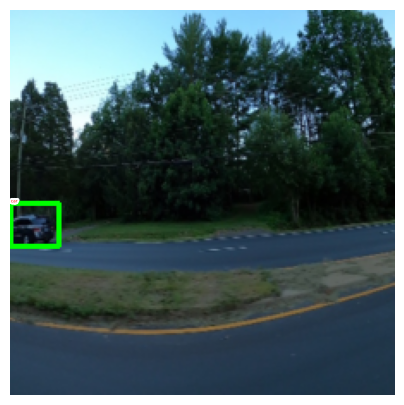

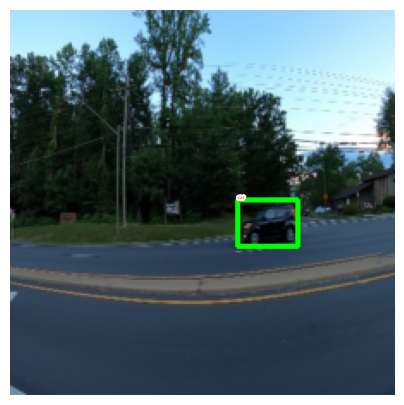

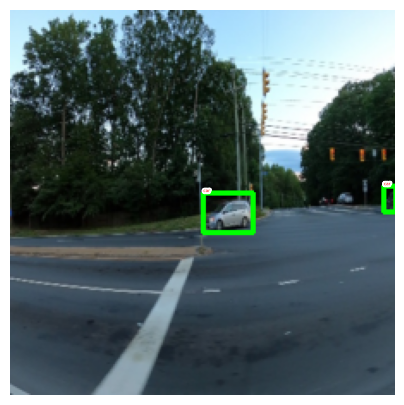

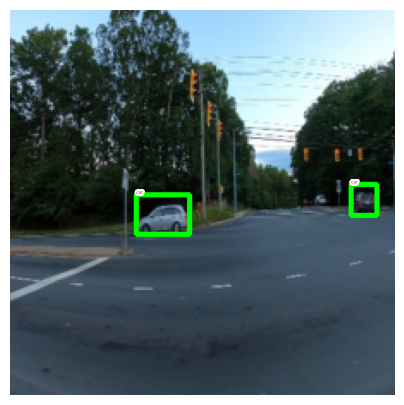

tensor([[[0.6706, 0.6706, 0.6706,  ..., 0.7373, 0.7882, 0.8941],
         [0.6706, 0.6745, 0.6745,  ..., 0.6824, 0.7804, 0.8510],
         [0.6784, 0.6784, 0.6784,  ..., 0.4353, 0.7059, 0.7686],
         ...,
         [0.1725, 0.1725, 0.1686,  ..., 0.2824, 0.2118, 0.1765],
         [0.1725, 0.1725, 0.1686,  ..., 0.1725, 0.1608, 0.1608],
         [0.1725, 0.1725, 0.1725,  ..., 0.1490, 0.1451, 0.1490]],

        [[0.8627, 0.8627, 0.8627,  ..., 0.8000, 0.8706, 0.9725],
         [0.8627, 0.8667, 0.8667,  ..., 0.7490, 0.8588, 0.9216],
         [0.8627, 0.8627, 0.8627,  ..., 0.4980, 0.7804, 0.8392],
         ...,
         [0.2118, 0.2118, 0.2078,  ..., 0.2431, 0.2078, 0.2039],
         [0.2118, 0.2118, 0.2078,  ..., 0.2000, 0.1961, 0.2000],
         [0.2118, 0.2118, 0.2118,  ..., 0.2039, 0.2039, 0.2000]],

        [[0.9922, 0.9922, 0.9922,  ..., 0.8588, 0.9098, 0.9882],
         [0.9922, 0.9961, 0.9961,  ..., 0.7843, 0.8941, 0.9451],
         [0.9961, 0.9961, 0.9961,  ..., 0.5098, 0.8078, 0.8784],
         ...,
         [0.2510, 0.2510, 0.2471,  ..., 0.1765, 0.1804, 0.2118],
         [0.2510, 0.2510, 0.2471,  ..., 0.2275, 0.2314, 0.2353],
         [0.2510, 0.2510, 0.2510,  ..., 0.2392, 0.2353, 0.2353]]],
       device='cuda:0')

torch.Size([3, 224, 224])

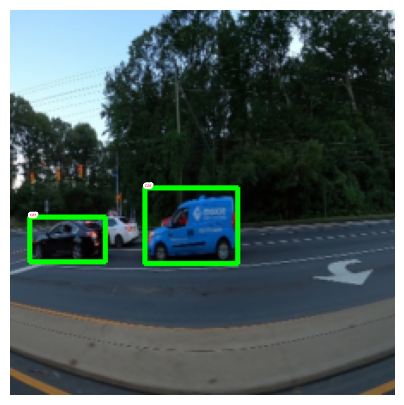

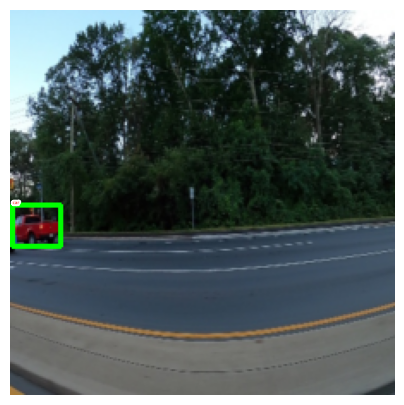

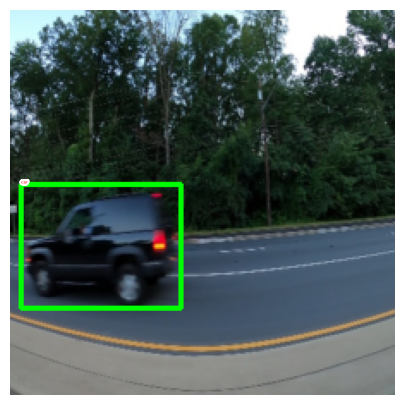

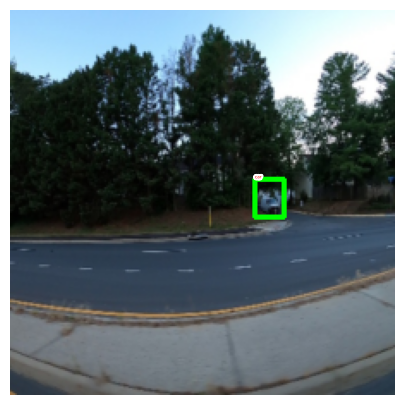

tensor([[[0.5686, 0.5686, 0.5725,  ..., 0.8784, 0.8824, 0.8902],
         [0.5686, 0.5725, 0.5686,  ..., 0.8902, 0.8941, 0.8980],
         [0.5725, 0.5725, 0.5725,  ..., 0.8980, 0.8980, 0.9020],
         ...,
         [0.1529, 0.1529, 0.1608,  ..., 0.4510, 0.3569, 0.2471],
         [0.1451, 0.1490, 0.1608,  ..., 0.2431, 0.1804, 0.1608],
         [0.1569, 0.1529, 0.1529,  ..., 0.1608, 0.1490, 0.1412]],

        [[0.7647, 0.7647, 0.7608,  ..., 0.9765, 0.9725, 0.9725],
         [0.7647, 0.7686, 0.7647,  ..., 0.9765, 0.9765, 0.9725],
         [0.7686, 0.7686, 0.7686,  ..., 0.9725, 0.9725, 0.9765],
         ...,
         [0.1922, 0.1961, 0.1961,  ..., 0.3608, 0.2902, 0.2118],
         [0.1961, 0.1922, 0.1961,  ..., 0.2196, 0.1882, 0.1882],
         [0.1922, 0.1882, 0.1922,  ..., 0.1922, 0.1922, 0.1922]],

        [[0.9647, 0.9686, 0.9725,  ..., 0.9922, 0.9922, 0.9922],
         [0.9647, 0.9725, 0.9725,  ..., 0.9961, 0.9961, 0.9961],
         [0.9686, 0.9725, 0.9765,  ..., 0.9961, 0.9961, 1.0000],
         ...,
         [0.2353, 0.2314, 0.2353,  ..., 0.2510, 0.2235, 0.1804],
         [0.2392, 0.2314, 0.2314,  ..., 0.1961, 0.1961, 0.2196],
         [0.2314, 0.2314, 0.2353,  ..., 0.2275, 0.2392, 0.2353]]],
       device='cuda:0')

torch.Size([3, 224, 224])

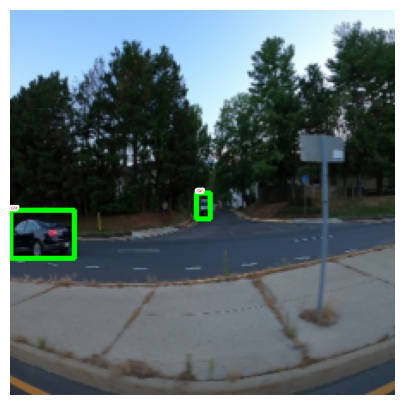

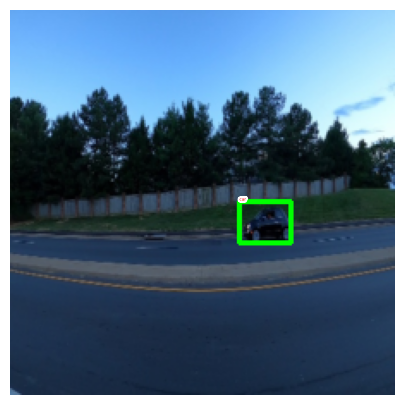

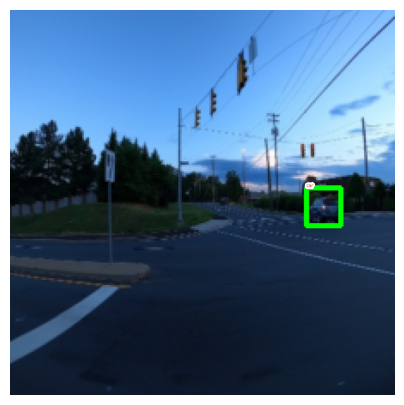

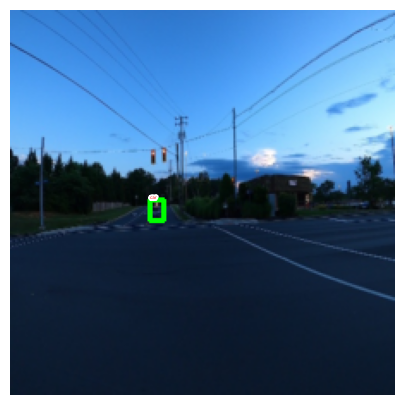

In [31]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    print(images[0])
    print(images[0].size())
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

In [16]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
torch.save(model.state_dict(), 'car-object-detection.h5')